In [ ]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [12]:
import os
import time
import uuid
import cv2

In [13]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
"""
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image{}'.format(imgnum))
    ret,frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
"""

"\ncap = cv2.VideoCapture(0)\nfor imgnum in range(number_images):\n    print('Collecting image{}'.format(imgnum))\n    ret,frame = cap.read()\n    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')\n    cv2.imwrite(imgname, frame)\n    cv2.imshow('frame',frame)\n    time.sleep(0.5)\n\n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()\n"

In [38]:
!labelme

In [14]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# To Avoid OOM errors on exagerated GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Resizing all images to a 1/5 of original size
from PIL import Image
import os

#Original Path
path = "D:/DS\Book-Judge/BookDataBase/"
resize_ratio = 0.2  # where 0.5 is half size, 2 is double size

def resize_aspect_fit():
    dirs = os.listdir(path)
    for item in dirs:
        if item == '.jpg':
            continue
        if os.path.isfile(path+item):
            image = Image.open(path+item)
            file_path, extension = os.path.splitext(path+item)

            new_image_height = int(image.size[0] / (1/resize_ratio))
            new_image_length = int(image.size[1] / (1/resize_ratio))

            image = image.resize((new_image_height, new_image_length), Image.ANTIALIAS)
            image.save(file_path + "_small" + extension, 'JPEG', quality=90)


resize_aspect_fit()

In [33]:
images = tf.data.Dataset.list_files('resizedata\\images\\*.jpg', shuffle=True)

In [34]:
#Checking that work as should
images.as_numpy_iterator().next()

b'resizedata\\images\\IMG_20230105_133627_small.jpg'

In [35]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [36]:
images = images.map(load_image)

In [ ]:
#Checking that work as should
images.as_numpy_iterator().next()

In [39]:
image_generator = images.batch(4).as_numpy_iterator()

In [40]:
plot_images = image_generator.next()

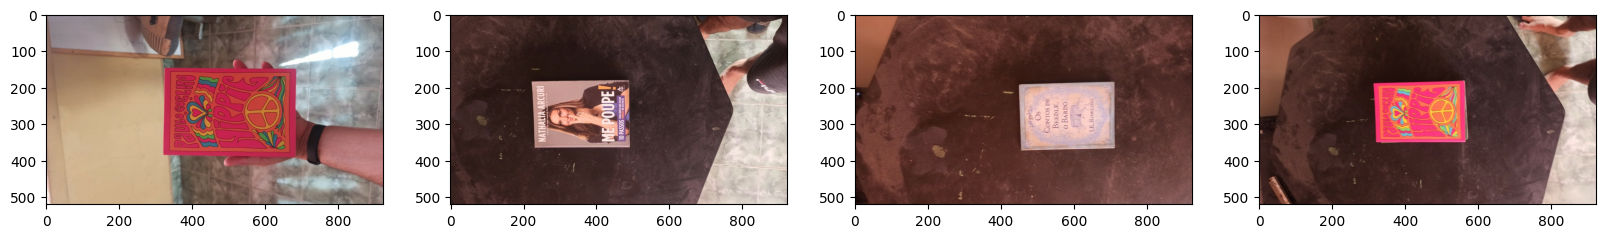

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [19]:
92*.7 # 64 to train 

64.39999999999999

In [20]:
92*.15 #14 to test and val

13.799999999999999

In [43]:
#Put the labels on respective folder
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('resizedata', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('resizedata', 'labels', filename)
        
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('resizedata', folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

In [44]:
import albumentations as alb

In [45]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p= 0.5), 
                         alb.RandomBrightnessContrast(p= 0.2),
                         alb.RandomGamma(p= 0.2), 
                         alb.RGBShift(p= 0.2), 
                         alb.VerticalFlip(p= 0.5),], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [46]:
img = cv2.imread(os.path.join('resizedata','train', 'images','IMG_20230105_133526_small.jpg'))

In [47]:
with open(os.path.join('resizedata', 'train', 'labels', 'IMG_20230105_133526_small.json'), 'r') as f:
    label = json.load(f)

In [48]:
label['shapes'][0]['points']

[[328.56976744186045, 185.0], [572.1744186046512, 351.86046511627904]]

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)

    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

coords_aux = bounding_box(label['shapes'][0]['points'])
coords_aux

In [49]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [50]:
coords

[328.56976744186045, 185.0, 572.1744186046512, 351.86046511627904]

In [51]:
coords = list(np.divide(coords, [924,520,924,520]))
coords

[0.3555949864089399,
 0.3557692307692308,
 0.6192363837712676,
 0.6766547406082289]

In [52]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['book'])

In [53]:
augmented['bboxes']

[(0.0, 0.31142118863049106, 0.3854005167958656, 0.6822222222222223)]

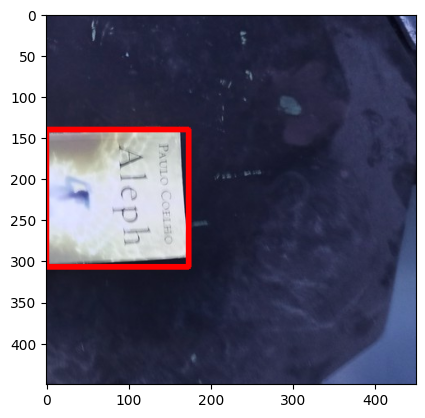

In [54]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 6)

plt.imshow(augmented['image'])

In [55]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('resizedata', partition, 'images')):
        img = cv2.imread(os.path.join('resizedata', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('resizedata', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords = [0,0,0,0]
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [924,520,924,520]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['book'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [56]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [57]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [58]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [59]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [60]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [61]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [63]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3840, 3840, 840, 840, 840, 840)

In [64]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [65]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1200)
test = test.batch(8)
test = test.prefetch(4)

In [66]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1200)
val = val.batch(8)
val = val.prefetch(4)

In [67]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.2311 , 0.555  , 0.832  , 0.961  ],
        [0.2605 , 0.2096 , 1.     , 0.769  ],
        [0.7944 , 0.2455 , 1.     , 0.6074 ],
        [0.     , 0.1597 , 0.6113 , 0.661  ],
        [0.104  , 0.3765 , 0.5767 , 0.7383 ],
        [0.     , 0.0462 , 0.05206, 0.501  ],
        [0.1982 , 0.2954 , 1.     , 0.855  ]], dtype=float16))

In [68]:
data_samples = train.as_numpy_iterator()

In [69]:
res = data_samples.next()

In [70]:
res[1][1][idx]

array([0.    , 0.2139, 0.4976, 0.75  ], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


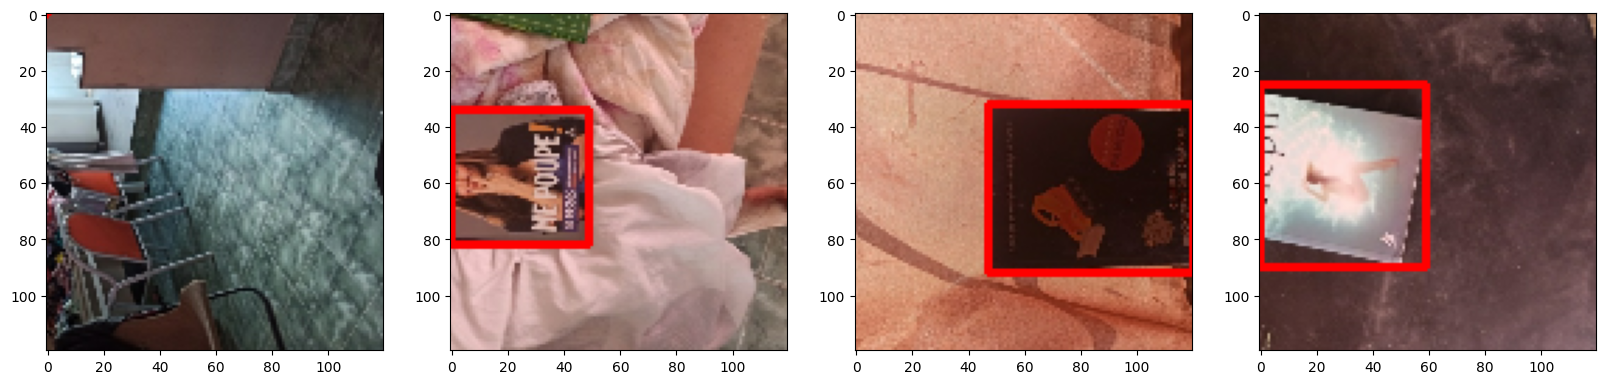

In [71]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [73]:
vgg = VGG16(include_top=False)

In [74]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [75]:
facetracker = build_model()

In [76]:
X, y = train.as_numpy_iterator().next()

In [77]:
X.shape

(8, 120, 120, 3)

In [78]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [79]:
classes, coords

(array([[0.49682817],
        [0.4124728 ],
        [0.46803635],
        [0.52479476],
        [0.4405678 ],
        [0.46875516],
        [0.4438916 ],
        [0.46320078]], dtype=float32),
 array([[0.6271294 , 0.4727662 , 0.35119006, 0.5623641 ],
        [0.60858023, 0.5158947 , 0.4052425 , 0.591897  ],
        [0.71444196, 0.4681806 , 0.3365802 , 0.57124126],
        [0.57422525, 0.5390543 , 0.31583813, 0.5919396 ],
        [0.62706953, 0.5440886 , 0.40447962, 0.61064893],
        [0.6457081 , 0.47444046, 0.22156407, 0.6314055 ],
        [0.57428336, 0.56058323, 0.3940838 , 0.5948655 ],
        [0.60007477, 0.5413671 , 0.38865015, 0.5687228 ]], dtype=float32))

In [80]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [81]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [82]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [83]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [84]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.08162>

In [85]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7202332>

In [86]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.08162>

In [87]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [88]:
model = FaceTracker(facetracker)

In [89]:
model.compile(opt, classloss, regressloss)

In [90]:
logdir='logs'

In [91]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

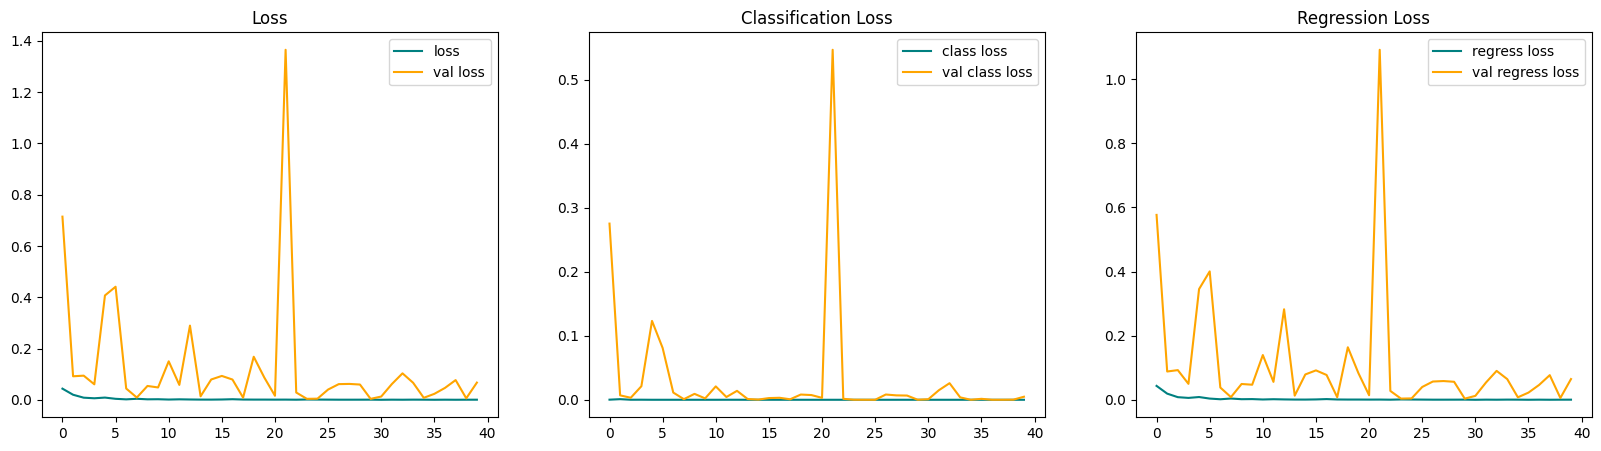

In [93]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [94]:
test_data = test.as_numpy_iterator()

In [110]:
test_sample = test_data.next()

In [111]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


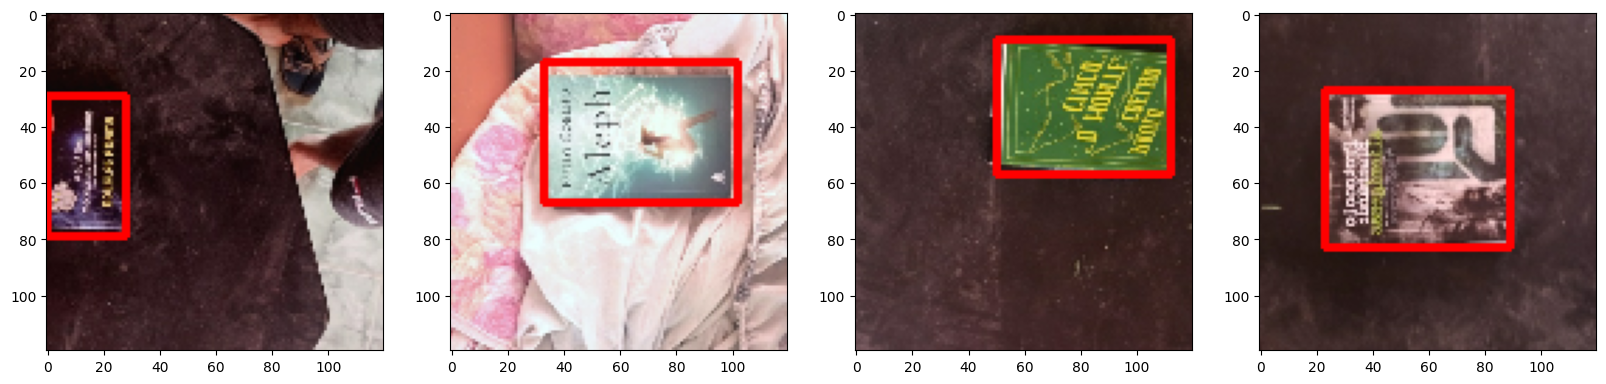

In [112]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [114]:
facetracker.save('booktracker.h5')

In [16]:
from tensorflow.keras.models import load_model

In [17]:
booktracker = load_model('booktracker.h5')

In [ ]:
pip uninstall opencv-python-headless -y 

In [ ]:
pip install opencv-python --upgrade

In [18]:
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = booktracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (220,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (220,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Livro', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    
    cv2.imshow('MauMauTracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()